In [1]:
import os
import glob
from math import floor

from IPython import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

import librosa

import tensorflow as tf
import tensorflow_hub as hub
import audioset.yamnet.params as yamnet_params
# import tensorflow_io as tfio  # no support for Apple M1. See: https://github.com/tensorflow/io/issues/1625

from lib_utility import load_wav_16k_mono, load_wav_16k_mono_segment

In [2]:
# Loading YAMNet from TensorFlow Hub
yamnet_model_handle = 'https://tfhub.dev/google/yamnet/1'
yamnet_model = hub.load(yamnet_model_handle)

In [3]:
# Parameters
sr = 16000

In [4]:
# class map
class_map_path = yamnet_model.class_map_path().numpy().decode('utf-8')
class_names =list(pd.read_csv(class_map_path)['display_name'])

2022-04-02 18:42:50.052268: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


In [5]:
for index, name in enumerate(class_names):
    print("{0} {1}".format(index, name))

0 Speech
1 Child speech, kid speaking
2 Conversation
3 Narration, monologue
4 Babbling
5 Speech synthesizer
6 Shout
7 Bellow
8 Whoop
9 Yell
10 Children shouting
11 Screaming
12 Whispering
13 Laughter
14 Baby laughter
15 Giggle
16 Snicker
17 Belly laugh
18 Chuckle, chortle
19 Crying, sobbing
20 Baby cry, infant cry
21 Whimper
22 Wail, moan
23 Sigh
24 Singing
25 Choir
26 Yodeling
27 Chant
28 Mantra
29 Child singing
30 Synthetic singing
31 Rapping
32 Humming
33 Groan
34 Grunt
35 Whistling
36 Breathing
37 Wheeze
38 Snoring
39 Gasp
40 Pant
41 Snort
42 Cough
43 Throat clearing
44 Sneeze
45 Sniff
46 Run
47 Shuffle
48 Walk, footsteps
49 Chewing, mastication
50 Biting
51 Gargling
52 Stomach rumble
53 Burping, eructation
54 Hiccup
55 Fart
56 Hands
57 Finger snapping
58 Clapping
59 Heart sounds, heartbeat
60 Heart murmur
61 Cheering
62 Applause
63 Chatter
64 Crowd
65 Hubbub, speech noise, speech babble
66 Children playing
67 Animal
68 Domestic animals, pets
69 Dog
70 Bark
71 Yip
72 Howl
73 Bow-wo

In [6]:
params = yamnet_params.Params(sample_rate=sr, patch_hop_seconds=1)
print("Sample rate =", params.sample_rate)

Sample rate = 16000


In [7]:
sound_path = "./sound"
sound_list = glob.glob(os.path.join(sound_path, "*.wav"))

# Example on one sound file, "this-american-life_getting-out.wav"

In [10]:
samples_curr = load_wav_16k_mono(sound_list[0])  # './sound/this-american-life_getting-out.wav'
scores, embeddings, spectrogram = yamnet_model(samples_curr)

In [11]:
scores = scores.numpy()
spectrogram = spectrogram.numpy()

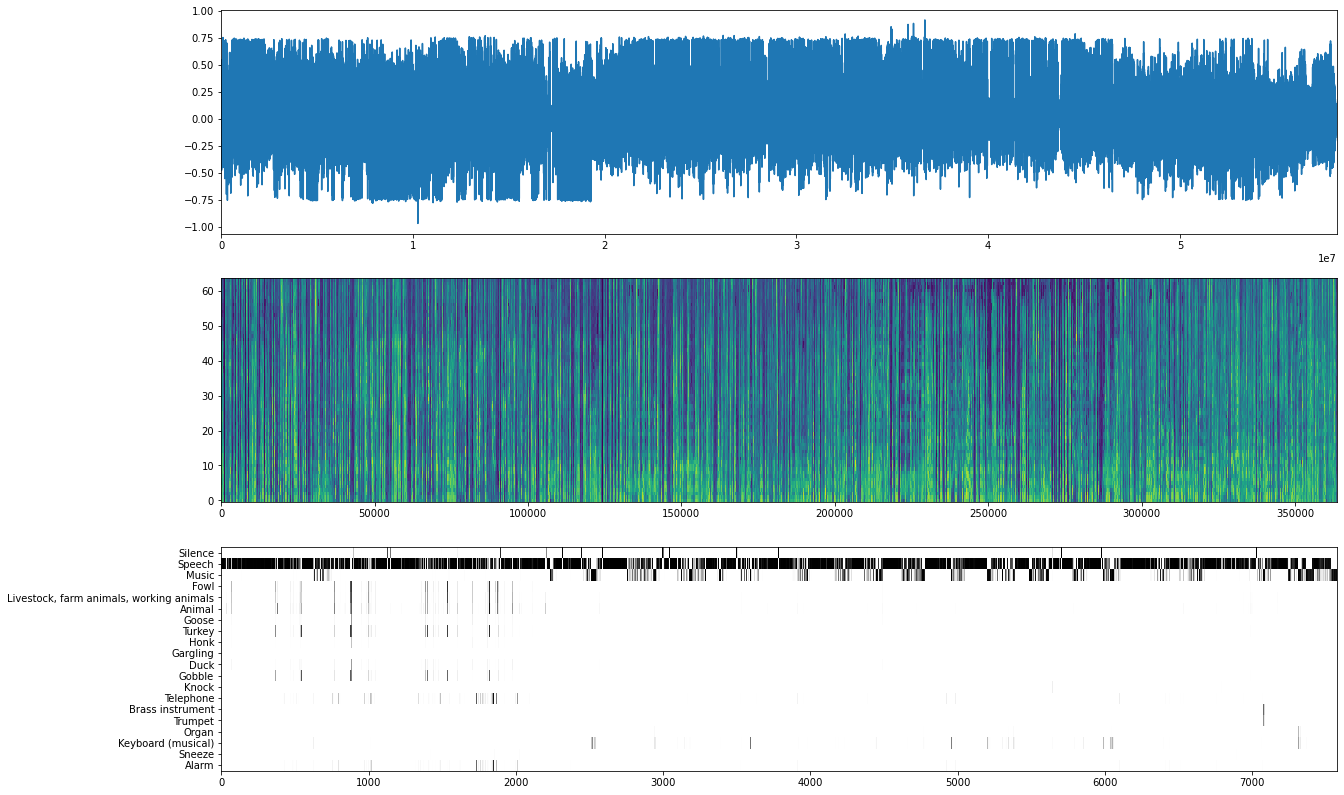

In [12]:
# Visualize the results.
plt.figure(figsize=(20, 14))

# Plot the waveform.
plt.subplot(3, 1, 1)
plt.plot(samples_curr)
plt.xlim([0, len(samples_curr)])

# Plot the log-mel spectrogram (returned by the model).
plt.subplot(3, 1, 2)
plt.imshow(spectrogram.T, aspect='auto', interpolation='nearest', origin='lower')
# Plot and label the model output scores for the top-scoring classes.
# mean_scores = np.mean(scores, axis=0)
mean_scores = np.max(scores, axis=0)
top_N = 20
top_class_indices = np.argsort(mean_scores)[::-1][:top_N]

# plot the topN classes
plt.subplot(3, 1, 3)
plt.imshow(scores[:, top_class_indices].T, aspect='auto', interpolation='nearest', cmap='gray_r')
# Compensate for the patch_window_seconds (0.96s) context window to align with spectrogram.
patch_padding = (params.patch_window_seconds / 2) / params.patch_hop_seconds
plt.xlim([-patch_padding, scores.shape[0] + patch_padding])
# Label the top_N classes.
yticks = range(0, top_N, 1)
plt.yticks(yticks, [class_names[top_class_indices[x]] for x in yticks])
_ = plt.ylim(-0.5 + np.array([top_N, 0]))


# Label speaker segments / paragrpahs with AudioSet

In [41]:
speaker_path = './sound/speaker_files'
audioset_path = './sound/audioset_files'
csv_list = sorted(glob.glob(os.path.join(speaker_path, '*.csv')))

In [42]:
csv_list

['./sound/speaker_files/99-invisible_matters-of-time.csv',
 './sound/speaker_files/99-invisible_stuff-the-british-stole.csv',
 './sound/speaker_files/a16z_crypto.csv',
 './sound/speaker_files/a16z_developers-as-creatives.csv',
 './sound/speaker_files/a16z_malaria-vaccine.csv',
 './sound/speaker_files/conan-obrien_cecily-strong.csv',
 './sound/speaker_files/conan-obrien_joel-mchale.csv',
 './sound/speaker_files/masters-of-scale_build-the-right-flywheel.csv',
 './sound/speaker_files/masters-of-scale_make-it-epic.csv',
 './sound/speaker_files/masters-of-scale_master-your-emotions.csv',
 './sound/speaker_files/my-first-million_how-to-build-a-community.csv',
 './sound/speaker_files/my-first-million_the-secret-to-being-great.csv',
 './sound/speaker_files/npr-politics_august-27th.csv',
 './sound/speaker_files/npr-politics_cutting-unemployment.csv',
 './sound/speaker_files/npr-politics_school-mask-ban.csv',
 './sound/speaker_files/radiolab_dark-side-of-the-earth.csv',
 './sound/speaker_files/r

In [39]:
if not os.path.exists(audioset_path):
    os.mkdir(audioset_path)

In [40]:
# for index, csv_file in enumerate(csv_list[0:1]):
for index, csv_file in enumerate(csv_list):
    print("{0} {1}".format(index, csv_file))
    df = pd.read_csv(csv_file)
    
    num_human = df['human_segment_id'].max()+1
    data = []
    for i in tqdm(range(num_human)):
        df_curr = df[df['human_segment_id']==i]
        start_time_curr = df_curr['start_time'].min()
        end_time_curr = df_curr['end_time'].max()
        # print("{0} {1}".format(start_time_curr, end_time_curr))
        
        sound_file = os.path.join('./sound', os.path.basename(csv_file)[:-3]+'wav')
        samples_segment = load_wav_16k_mono_segment(sound_file, start_time_curr, end_time_curr)
        # print(samples_segment.shape)
        
        scores, embeddings, spectrogram = yamnet_model(samples_segment)
        # find classes with large confidence
        class_ids = np.where(scores.numpy().max(axis=0) > 0.5)[0]
        scores = scores.numpy()[:, class_ids].mean(axis=0)
        class_labels = [class_names[j] for j in class_ids]
        
        # combine tokens into a paragraph
        text = df_curr['content'].values.tolist()
        text = " ".join(text)
        text = text.replace(' ,', ',')
        text = text.replace(' .', '.')
        text = text.replace(' ;', '.')
        text = text.replace(' !', '.')
        text = text.replace(' ?', '.')
        
        # data
        data.append({'speaker_id': i, 
                     'class_labels': class_labels, 
                     'scores': scores,
                     'start_time': start_time_curr, 
                     'end_time': end_time_curr,
                     'duration': end_time_curr - start_time_curr,
                     'content': text,
                    })
    
    df_paragraph = pd.DataFrame(data)
    # df_paragraph.to_csv(csv_file[:-4]+'_paragraph.csv', index=False)
    df_paragraph.to_csv(os.path.join(audioset_path, os.path.basename(csv_file)), index=False)

0 ./sound/speaker_files/the-internet-says-its-true_hollywood.csv


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 74/74 [00:10<00:00,  7.06it/s]


1 ./sound/speaker_files/npr-politics_cutting-unemployment.csv


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00, 10.20it/s]


2 ./sound/speaker_files/a16z_developers-as-creatives.csv


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:08<00:00,  4.85it/s]


3 ./sound/speaker_files/a16z_malaria-vaccine.csv


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:10<00:00,  5.89it/s]


4 ./sound/speaker_files/my-first-million_how-to-build-a-community.csv


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 146/146 [00:31<00:00,  4.65it/s]


5 ./sound/speaker_files/masters-of-scale_master-your-emotions.csv


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:12<00:00,  5.42it/s]


6 ./sound/speaker_files/radiolab_dinopocalypse-redux.csv


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 129/129 [00:20<00:00,  6.30it/s]


7 ./sound/speaker_files/this-american-life_essential.csv


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 142/142 [00:28<00:00,  4.90it/s]


8 ./sound/speaker_files/99-invisible_matters-of-time.csv


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:23<00:00,  6.61it/s]


9 ./sound/speaker_files/npr-politics_august-27th.csv


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:07<00:00,  8.63it/s]


10 ./sound/speaker_files/99-invisible_stuff-the-british-stole.csv


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 115/115 [00:17<00:00,  6.70it/s]


11 ./sound/speaker_files/a16z_crypto.csv


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:08<00:00,  4.71it/s]


12 ./sound/speaker_files/this-american-life_getting-out.csv


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 123/123 [00:26<00:00,  4.60it/s]


13 ./sound/speaker_files/npr-politics_school-mask-ban.csv


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:03<00:00,  7.53it/s]


14 ./sound/speaker_files/my-first-million_the-secret-to-being-great.csv


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 71/71 [00:12<00:00,  5.52it/s]


15 ./sound/speaker_files/masters-of-scale_build-the-right-flywheel.csv


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:19<00:00,  6.06it/s]


16 ./sound/speaker_files/the-internet-says-its-true_hidden-village.csv


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:05<00:00,  5.29it/s]


17 ./sound/speaker_files/radiolab_dark-side-of-the-earth.csv


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 85/85 [00:09<00:00,  9.10it/s]


18 ./sound/speaker_files/conan-obrien_cecily-strong.csv


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 211/211 [00:33<00:00,  6.23it/s]


19 ./sound/speaker_files/masters-of-scale_make-it-epic.csv


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 129/129 [00:22<00:00,  5.71it/s]


20 ./sound/speaker_files/conan-obrien_joel-mchale.csv


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 202/202 [00:40<00:00,  4.94it/s]


## Example

In [34]:
os.path.join(audioset_path, csv_file)

'./sound/audioset_files/./sound/speaker_files/the-internet-says-its-true_hollywood.csv'

In [29]:
df

,speaker_id,class_labels,scores,content,start_time,end_time
0,0,"['Speech', 'Crowd', 'Music', 'Silence']",[0.43504202 0.02308444 0.11472886 0.10121714],"['Listener', 'support', 'it', 'w', 'NYC', 'stu...",3.92,28.32
1,1,"['Speech', 'Cheering', 'Applause', 'Bell', 'Ch...",[0.40925354 0.06876926 0.07331113 0.04881127 0...,"['Ladies', 'and', 'John', ',', 'and', 'please'...",28.96,56.56
2,2,['Speech'],[0.5288155],"['We', 'were', 'live', 'at', 'the', 'paramount...",56.80,66.16
3,3,"['Speech', 'Music']",[0.9129495 0.08955874],"['It', 'was', 'a', 'show', 'that', 'we', 'did'...",66.40,72.08
4,4,['Speech'],[0.8031228],"['We', 'had', 'huge', ',', 'yes', 'puppets', '...",72.08,77.92
...,...,...,...,...,...,...
124,124,"['Speech', 'Music', 'Musical instrument', 'Per...",[0.03991201 0.733477 0.15714894 0.17494267 0...,"['I', 'rubber', 'koww', 'thanks', 'for', 'list...",2698.48,2717.20
125,125,"['Speech', 'Music']",[0.43644008 0.13434604],"['This', 'is', 'Jason', 'studs', '.', 'Still',...",2717.36,2755.76
126,126,"['Speech', 'Music']",[0.6845171 0.50055647],"['Twenty', 'years', 'ago', ',', 'the', 'Septem...",2763.28,2774.48
127,127,"['Speech', 'Music']",[0.27268022 0.40535474],"[""It's"", 'always', 'easy', 'in', 'hindsight', ...",2774.48,2777.12


In [27]:
df_paragraph

,speaker_id,class_labels,scores,start_time,end_time,duration,content
0,0,"[Speech, Music]","[0.7562406, 0.42408383]",0.24,70.88,70.64,"California, welcome to the Internet, says it's..."
1,1,"[Speech, Music, Silence]","[0.8195112, 0.5254799, 0.00044235945]",71.28,659.68,588.40,"Thanks Marty, I got this link and I don't know..."
2,2,[Speech],[0.978001],661.28,702.08,40.80,Lately I've been acting on show times black Mo...
3,3,[Speech],[0.9146328],702.48,744.96,42.48,This may be a common question that that you ge...
4,4,[Speech],[0.9887947],745.04,787.44,42.40,"They came out to yes, barb and Stargo to ved. ..."
...,...,...,...,...,...,...,...
69,69,"[Speech, Music]","[0.7838461, 0.17223752]",1864.08,1875.60,11.52,They can always find me on instagram at it's a...
70,70,"[Speech, Music]","[0.8787019, 0.24262464]",1875.92,1877.44,1.52,Thank you for having me Michael.
71,71,"[Speech, Music]","[0.7957699, 0.59248155]",1879.76,1891.12,11.36,"Well, that's the show for this week. Thank you..."
72,72,"[Speech, Music]","[0.8994613, 0.52577496]",1891.52,1929.44,37.92,"Thank you for listening to the Internet, Physi..."
